In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import torch
from scipy import stats
from torch.nn.utils.rnn import pad_sequence
from sklearn.neural_network import MLPRegressor
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from sklearn.metrics import mean_squared_error, r2_score
import time
import os

In [ ]:
def create_statistics(vals):
    values = vals.copy()
    mols = [Chem.MolFromSmiles(x) for x in values[SMILES_COLUMN]]
    
    atom_count = [mol.GetNumAtoms() for mol in mols]
    values['atom_count'] = pd.Series(atom_count)
    
    values['ring_count'] = pd.Series([mol.GetRingInfo().NumRings() for mol in mols])
    
    mol_atoms = [mol.GetAtoms() for mol in mols]
    non_simple_atom_count = [sum((num.GetAtomicNum() not in [1, 6, 8, 7]) for num in m_atoms) for m_atoms in mol_atoms]
    values['non_organogens_count'] = pd.Series(non_simple_atom_count)
    
    values['non_organogens_percent'] = values.non_organogens_count / values.atom_count *100
    
    benzene_smiles = 'C1=CC=CC=C1'
    pattern = Chem.MolFromSmiles(benzene_smiles)
    values['aromatic_count'] = pd.Series([len(mol.GetSubstructMatches(pattern)) for mol in mols])
    
    values['aromatic_rings_percent'] = values.aromatic_count / values.ring_count *100
    values['aromatic_rings_percent'] = values['aromatic_rings_percent'].fillna(0)
    
    values['bond_count'] =  [len(mol.GetBonds()) for mol in mols]
    values['aromatic_bond_count'] = [sum(bond.GetIsAromatic() for bond in mol.GetBonds()) for mol in mols]
    values['aromatic_bond_percent'] = values.aromatic_bond_count / values.bond_count * 100
    
    values_list = [pd.Series(Chem.CanonicalRankAtoms(mol, breakTies=False)).value_counts() for mol in mols]
    values['is_symmetric'] =  [(len(values) - 1 <= len(values[values % 2 == 0])) or (len(values) - 1 <= len(values[(values % 2 == 1) & (values > 1)])) for values in values_list]
    
    return values

In [83]:

FILENAME = "test_predictions.csv"

SMILES_COLUMN = 'smiles'
VALUE_COLUMN = 'logD'
PRED_COLUMN = 'logD_pred'
ERROR_COLUMN = 'Squared Error'

FOLDS= 4

N_VALUES = 200

In [84]:
NUM_EXPS = [312, 313, 314]

In [91]:
kruskal_stistics = []
for NUM_EXP in NUM_EXPS:
    kruskal_stats = {}
    DATA_PATH = "../../data/raw/baselines/dmpnn/logs/exp_"+str(NUM_EXP)+'/folds'
    rmse = []
    
    preds = []

    for FOLD in range(FOLDS):
        test_prediction = pd.read_csv(os.path.join(DATA_PATH,'fold_'+str(FOLD), FILENAME))
        preds.append(test_prediction[PRED_COLUMN].values)
        smiles = test_prediction[SMILES_COLUMN]
        values = test_prediction[VALUE_COLUMN]

    test_prediction = pd.DataFrame(columns = [SMILES_COLUMN, PRED_COLUMN, VALUE_COLUMN])
    test_prediction[SMILES_COLUMN] = smiles
    test_prediction[VALUE_COLUMN] = values
    test_prediction[PRED_COLUMN] = np.mean(np.array(preds), axis = 0)
    print('Test RMSE Averaging over folds = ', mean_squared_error(test_prediction[VALUE_COLUMN], test_prediction[PRED_COLUMN])**0.5)    
    for FOLD in range(FOLDS):
        import json
        with open(os.path.join(DATA_PATH,'fold_'+str(FOLD), 'args.json'), 'r') as f:
            args = json.load(f)
        test_prediction = pd.read_csv(os.path.join(DATA_PATH,'fold_'+str(FOLD), FILENAME))
        
        rmse.append(mean_squared_error(test_prediction[VALUE_COLUMN], test_prediction[PRED_COLUMN])**0.5)
    if args['additional_encoder']:
        kruskal_stats['Model'] = 'StructGNN with ext valence'
        print('StructGNN with ext valence')
    else:
        kruskal_stats['Model'] = 'DMPNN'
        print('DMPNN')
    print(args['features_generator'])
    kruskal_stats['Model'] += ' with '+' '.join(args['features_generator'][0].split('_'))
    print('All RMSE ', rmse)
    print('Test RMSE = ', np.mean(rmse))
    FOLD = np.argmin(np.abs(np.array(rmse)-np.mean(rmse)))
    print('Closest Fold is ', FOLD)
    
    
    test_prediction = pd.read_csv(os.path.join(DATA_PATH,'fold_'+str(FOLD), FILENAME))
    test_prediction[ERROR_COLUMN] = (test_prediction[VALUE_COLUMN] - test_prediction[PRED_COLUMN]) ** 2    
    test_prediction_sorted = test_prediction.sort_values(by=[ERROR_COLUMN], ascending=False)    
    
    compare_data_with_stats = create_statistics(test_prediction_sorted)
    
    best_n_vals = compare_data_with_stats.iloc[-N_VALUES:]
    worst_n_vals = compare_data_with_stats.iloc[:n_values]
    
    
    for stat in compare_data_with_stats.columns:
        if stat not in [SMILES_COLUMN, VALUE_COLUMN, PRED_COLUMN, ERROR_COLUMN]:
            kruskal_stats[stat] = stats.kruskal(best_n_vals[stat], worst_n_vals[stat])[1]
            
    symmetric_rull = lambda values: (len(values) - 1 <= len(values[values % 2 == 0])) or (len(values) - 1 <= len(values[(values % 2 == 1) & (values > 1)]))
    values_list = [pd.Series(Chem.CanonicalRankAtoms(Chem.MolFromSmiles(smiles), breakTies=False)).value_counts() for smiles in compare_data_with_stats[SMILES_COLUMN]]
    symmetric_indices = [symmetric_rull(values) for values in values_list]
    not_symmetric_indices = [not e for e in symmetric_indices]
    
    symmetric_y_predicted = compare_data_with_stats[PRED_COLUMN][symmetric_indices]
    symmetric_y_expected = compare_data_with_stats[VALUE_COLUMN][symmetric_indices]    
    not_symmetric_y_predicted = compare_data_with_stats[PRED_COLUMN][not_symmetric_indices]    
    not_symmetric_y_expected = compare_data_with_stats[VALUE_COLUMN][not_symmetric_indices]   
    
    from sklearn.metrics import mean_squared_error    
    
    kruskal_stats['symmetric test RMSE'] =  mean_squared_error(symmetric_y_expected, symmetric_y_predicted, squared=False)
    kruskal_stats['symmetric test R2'] =  r2_score(symmetric_y_expected, symmetric_y_predicted)
    print("Test symmetric RMSE =", mean_squared_error(symmetric_y_expected, symmetric_y_predicted, squared=False))
    print("Test symmetric R2-score is {0}".format(r2_score(symmetric_y_expected, symmetric_y_predicted)))
    
    kruskal_stats['non-symmetric test RMSE'] = mean_squared_error(not_symmetric_y_expected, not_symmetric_y_predicted, squared=False)
    kruskal_stats['non-symmetric test R2'] = r2_score(not_symmetric_y_expected, not_symmetric_y_predicted)
    print("Test not symmetric RMSE =", mean_squared_error(not_symmetric_y_expected, not_symmetric_y_predicted, squared=False))
    print("Test not symmetric R2-score is {0}".format(r2_score(not_symmetric_y_expected, not_symmetric_y_predicted)))
    
    kruskal_stistics.append(kruskal_stats)
    print()
    print('===')
    print()
    
kruskal_stistics = pd.DataFrame(kruskal_stistics)
kruskal_stistics.head()

Test RMSE Averaging over folds =  0.5473526435468319
DMPNN
['rdkit_wo_fragments_and_counts']
All RMSE  [0.559065874061998, 0.5936375813367104, 0.6157155018611757, 0.5880178308429295]
Test RMSE =  0.5891091970257034
Closest Fold is  3
Test symmetric RMSE = 0.8899902760617631
Test symmetric R2-score is 0.41180522427449207
Test not symmetric RMSE = 0.5843276374731529
Test not symmetric R2-score is 0.7638897802779961

===

Test RMSE Averaging over folds =  0.5491276117437536
StructGNN with ext valence
['rdkit_wo_fragments_and_counts']
All RMSE  [0.5716943797749734, 0.5931031939863507, 0.6113007322812698, 0.5890512868387149]
Test RMSE =  0.5912873982203272
Closest Fold is  1
Test symmetric RMSE = 1.291685362463894
Test symmetric R2-score is -0.23897948632650357
Test not symmetric RMSE = 0.5822445812664928
Test not symmetric R2-score is 0.7655701875320199

===

Test RMSE Averaging over folds =  0.5638603399915347
DMPNN
['rdkit_2d_normalized_best']
All RMSE  [0.5940811975214155, 0.61390949804

,Model,atom_count,ring_count,non_organogens_count,non_organogens_percent,aromatic_count,aromatic_rings_percent,bond_count,aromatic_bond_count,aromatic_bond_percent,is_symmetric,symmetric test RMSE,symmetric test R2,non-symmetric test RMSE,non-symmetric test R2
0,DMPNN with rdkit wo fragments and counts,0.263256,0.514386,0.963104,0.685310,0.026405,0.066609,0.062353,0.580612,0.382044,0.177524,0.889990,0.411805,0.584328,0.763890
1,StructGNN with ext valence with rdkit wo fragm...,0.881610,0.235047,0.909388,0.905048,0.576215,0.424160,0.966854,0.404218,0.642269,0.024617,1.291685,-0.238979,0.582245,0.765570
2,DMPNN with rdkit 2d normalized best,0.801064,0.617603,0.249671,0.250586,0.067327,0.205758,0.606816,0.512975,0.354437,0.177524,0.912423,0.381780,0.600136,0.750942


In [90]:
kruskal_stistics

[{'Model': 'DMPNN with rdkit wo fragments and counts',
  'atom_count': 0.26325609078261225,
  'ring_count': 0.514385913559005,
  'non_organogens_count': 0.9631044436330153,
  'non_organogens_percent': 0.685310421489181,
  'aromatic_count': 0.026405250375708903,
  'aromatic_rings_percent': 0.06660943308346567,
  'bond_count': 0.06235318100935161,
  'aromatic_bond_count': 0.5806120270829529,
  'aromatic_bond_percent': 0.3820436227708497,
  'is_symmetric': 0.1775243657189498,
  'symmetric test RMSE': 0.8899902760617631,
  'symmetric test R2': 0.41180522427449207,
  'non-symmetric test RMSE': 0.5843276374731529,
  'non-symmetric test R2': 0.7638897802779961}]

# Draft

# Get predictions

In [ ]:
NUM_EXP = 312
DATA_PATH = "../../data/raw/baselines/dmpnn/logs/exp_"+str(NUM_EXP)+'/folds'

## Average ensemble of models

In [6]:
preds = []

for FOLD in range(FOLDS):
    test_prediction = pd.read_csv(os.path.join(DATA_PATH,'fold_'+str(FOLD), FILENAME))
    preds.append(test_prediction[PRED_COLUMN].values)
    smiles = test_prediction[SMILES_COLUMN]
    values = test_prediction[VALUE_COLUMN]
    
test_prediction = pd.DataFrame(columns = [SMILES_COLUMN, PRED_COLUMN, VALUE_COLUMN])
test_prediction[SMILES_COLUMN] = smiles
test_prediction[VALUE_COLUMN] = values
test_prediction[PRED_COLUMN] = np.mean(np.array(preds), axis = 0)

In [7]:
test_prediction.head()

,smiles,logD_pred,logD
0,O=C(NC[C@@H](O)CN1CCC(Oc2ccc(Cl)c(Cl)c2)CC1)n1...,3.389678,4.46
1,OCC(O)CN1CCN(c2ccccc2)CC1,0.599824,0.40
2,Cc1ccc(OCC(=O)O)c(-n2nc3ccccc3n2)c1,-0.426052,-0.84
3,O=c1cc(OCc2ccccc2)ccn1-c1ccc2c(cnn2CCN2CCCC2)c1,1.845766,2.00
4,N#C[C@@H]1CCCN1C(=O)CNC12CC3CC(CC(O)(C3)C1)C2,0.613210,-0.48


In [8]:
print('Test RMSE = ', mean_squared_error(test_prediction[VALUE_COLUMN], test_prediction[PRED_COLUMN])**0.5)

Test RMSE =  0.5473526435468319


## Average scores

In [11]:
rmse = []
for FOLD in range(FOLDS):
    test_prediction = pd.read_csv(os.path.join(DATA_PATH,'fold_'+str(FOLD), FILENAME))
    rmse.append(mean_squared_error(test_prediction[VALUE_COLUMN], test_prediction[PRED_COLUMN])**0.5)

print('All RMSE ', rmse)
print('Test RMSE = ', np.mean(rmse))

All RMSE  [0.559065874061998, 0.5936375813367104, 0.6157155018611757, 0.5880178308429295]
Test RMSE =  0.5891091970257034


## Calculate error

In [15]:
FOLD = 3 # closest to mean value

ERROR_COLUMN = 'Squared Error'

In [16]:
test_prediction = pd.read_csv(os.path.join(DATA_PATH,'fold_'+str(FOLD), FILENAME))

In [18]:
test_prediction[ERROR_COLUMN] = (test_prediction[VALUE_COLUMN] - test_prediction[PRED_COLUMN]) ** 2

In [28]:
test_prediction_sorted = test_prediction.sort_values(by=[ERROR_COLUMN], ascending=False)

In [29]:
def create_statistics(vals):
    values = vals.copy()
    mols = [Chem.MolFromSmiles(x) for x in values[SMILES_COLUMN]]
    
    atom_count = [mol.GetNumAtoms() for mol in mols]
    values['atom_count'] = pd.Series(atom_count)
    
    values['ring_count'] = pd.Series([mol.GetRingInfo().NumRings() for mol in mols])
    
    mol_atoms = [mol.GetAtoms() for mol in mols]
    non_simple_atom_count = [sum((num.GetAtomicNum() not in [1, 6, 8, 7]) for num in m_atoms) for m_atoms in mol_atoms]
    values['non_organogens_count'] = pd.Series(non_simple_atom_count)
    
    values['non_organogens_percent'] = values.non_organogens_count / values.atom_count *100
    
    benzene_smiles = 'C1=CC=CC=C1'
    pattern = Chem.MolFromSmiles(benzene_smiles)
    values['aromatic_count'] = pd.Series([len(mol.GetSubstructMatches(pattern)) for mol in mols])
    
    values['aromatic_rings_percent'] = values.aromatic_count / values.ring_count *100
    values['aromatic_rings_percent'] = values['aromatic_rings_percent'].fillna(0)
    
    values['bond_count'] =  [len(mol.GetBonds()) for mol in mols]
    values['aromatic_bond_count'] = [sum(bond.GetIsAromatic() for bond in mol.GetBonds()) for mol in mols]
    values['aromatic_bond_percent'] = values.aromatic_bond_count / values.bond_count * 100
    
    values_list = [pd.Series(Chem.CanonicalRankAtoms(mol, breakTies=False)).value_counts() for mol in mols]
    values['is_symmetric'] =  [(len(values) - 1 <= len(values[values % 2 == 0])) or (len(values) - 1 <= len(values[(values % 2 == 1) & (values > 1)])) for values in values_list]
    
    return values

In [30]:
compare_data_with_stats = create_statistics(test_prediction_sorted)

In [32]:
compare_data_with_stats.head()

,smiles,logD,logD_pred,Squared Error,atom_count,ring_count,non_organogens_count,non_organogens_percent,aromatic_count,aromatic_rings_percent,bond_count,aromatic_bond_count,aromatic_bond_percent,is_symmetric
338,O=C(O)c1ccc2cccc(O)c2n1,3.30,-0.856671,17.277911,41,4,2,4.878049,3,75.000000,15,11,73.333333,False
297,O=Cc1ccccc1B(O)O,0.83,-2.789887,13.103584,17,3,0,0.000000,2,66.666667,11,6,54.545455,False
296,CCCCc1c(O)n(-c2ccccc2)n(-c2ccccc2)c1=O,0.45,2.912228,6.062566,32,2,4,12.500000,1,50.000000,25,17,68.000000,False
517,C=CCCCCCCCCC(O)Nc1ccc(=O)[nH]c1O,2.64,0.205992,5.924396,32,3,1,3.125000,2,66.666667,21,6,28.571429,False
267,Cc1c[nH]c(=Cc2c(O)[nH]c3ccccc23)c1=CCC(=O)O,1.20,-0.973261,4.723065,32,4,0,0.000000,1,25.000000,24,15,62.500000,False


# Get best and worst predictions

In [33]:
n_values = 200

In [39]:
best_n_vals = compare_data_with_stats.iloc[-n_values:]

In [42]:
worst_n_vals = compare_data_with_stats.iloc[:n_values]

# Get Kruskal Stats

In [43]:
print(stats.kruskal(best_n_vals.atom_count, worst_n_vals.atom_count))

KruskalResult(statistic=1.2515528903986406, pvalue=0.26325609078261225)


<AxesSubplot:xlabel='atom_count'>

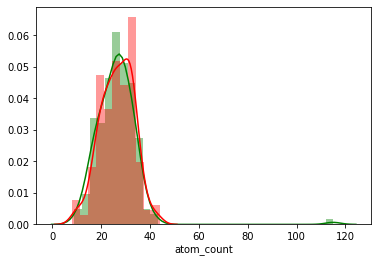

In [44]:
sns.distplot(best_n_vals.atom_count, color='g')
sns.distplot(worst_n_vals.atom_count, color='r')

In [45]:
print(stats.kruskal(best_n_vals.ring_count, worst_n_vals.ring_count))

KruskalResult(statistic=0.4251348446895487, pvalue=0.514385913559005)


<AxesSubplot:xlabel='ring_count'>

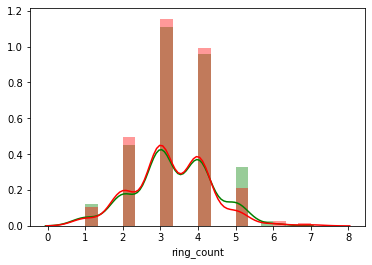

In [46]:
sns.distplot(best_n_vals.ring_count, color='g')
sns.distplot(worst_n_vals.ring_count, color='r')

In [47]:
print(stats.kruskal(best_n_vals.non_organogens_count, worst_n_vals.non_organogens_count))

KruskalResult(statistic=0.002139822408633849, pvalue=0.9631044436330153)


<AxesSubplot:xlabel='non_organogens_count'>

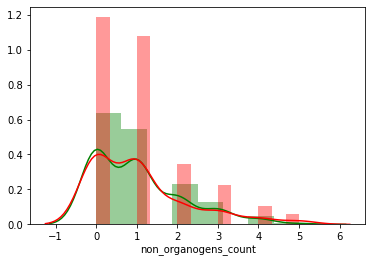

In [48]:
sns.distplot(best_n_vals.non_organogens_count, color='g')
sns.distplot(worst_n_vals.non_organogens_count, color='r')

In [49]:
print(stats.kruskal(best_n_vals.non_organogens_percent, worst_n_vals.non_organogens_percent))

KruskalResult(statistic=0.16420918465347037, pvalue=0.685310421489181)


<AxesSubplot:xlabel='non_organogens_percent'>

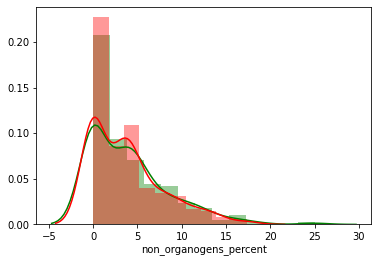

In [50]:
sns.distplot(best_n_vals.non_organogens_percent, color='g')
sns.distplot(worst_n_vals.non_organogens_percent, color='r')

In [51]:
print(stats.kruskal(best_n_vals.aromatic_count, worst_n_vals.aromatic_count))

KruskalResult(statistic=4.92928437173399, pvalue=0.026405250375708903)


<AxesSubplot:xlabel='aromatic_count'>

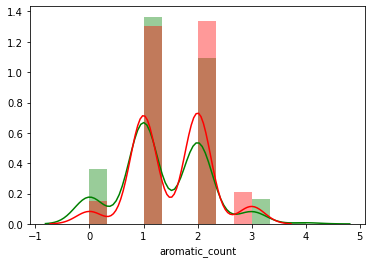

In [52]:
sns.distplot(best_n_vals.aromatic_count, color='g')
sns.distplot(worst_n_vals.aromatic_count, color='r')

In [53]:
print(stats.kruskal(best_n_vals.aromatic_rings_percent, worst_n_vals.aromatic_rings_percent))

KruskalResult(statistic=3.364657506062991, pvalue=0.06660943308346567)


<AxesSubplot:xlabel='aromatic_rings_percent'>

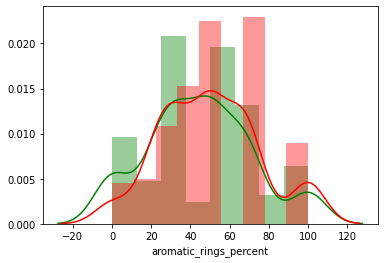

In [54]:
sns.distplot(best_n_vals.aromatic_rings_percent, color='g')
sns.distplot(worst_n_vals.aromatic_rings_percent, color='r')

In [55]:
print(stats.kruskal(best_n_vals.aromatic_bond_percent, worst_n_vals.aromatic_bond_percent))

KruskalResult(statistic=0.7641155819018015, pvalue=0.3820436227708497)


<AxesSubplot:xlabel='aromatic_bond_percent'>

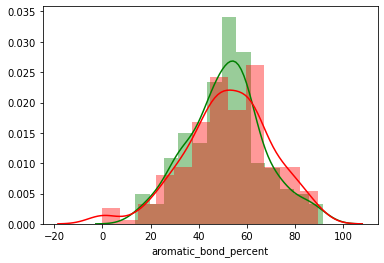

In [56]:
sns.distplot(best_n_vals.aromatic_bond_percent, color='g')
sns.distplot(worst_n_vals.aromatic_bond_percent, color='r')

In [57]:
print(stats.kruskal(best_n_vals.aromatic_bond_count, worst_n_vals.aromatic_bond_count))

KruskalResult(statistic=0.3052462596453758, pvalue=0.5806120270829529)


<AxesSubplot:xlabel='aromatic_bond_count'>

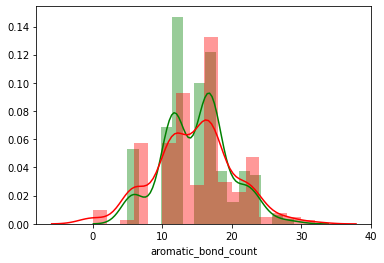

In [58]:
sns.distplot(best_n_vals.aromatic_bond_count, color='g')
sns.distplot(worst_n_vals.aromatic_bond_count, color='r')

# Symmetric metrics

In [60]:
symmetric_rull = lambda values: (len(values) - 1 <= len(values[values % 2 == 0])) or (len(values) - 1 <= len(values[(values % 2 == 1) & (values > 1)]))

In [62]:
values_list = [pd.Series(Chem.CanonicalRankAtoms(Chem.MolFromSmiles(smiles), breakTies=False)).value_counts() for smiles in compare_data_with_stats[SMILES_COLUMN]]
symmetric_indices = [symmetric_rull(values) for values in values_list]
not_symmetric_indices = [not e for e in symmetric_indices]

In [64]:
symmetric_y_predicted = compare_data_with_stats[PRED_COLUMN][symmetric_indices]


In [65]:
symmetric_y_expected = compare_data_with_stats[VALUE_COLUMN][symmetric_indices]

In [67]:
not_symmetric_y_predicted = compare_data_with_stats[PRED_COLUMN][not_symmetric_indices]

In [68]:
not_symmetric_y_expected = compare_data_with_stats[VALUE_COLUMN][not_symmetric_indices]

In [69]:
from sklearn.metrics import mean_squared_error

In [70]:
print("Test symmetric RMSE =", mean_squared_error(symmetric_y_expected, symmetric_y_predicted, squared=False))
print("Test symmetric R2-score is {0}".format(r2_score(symmetric_y_expected, symmetric_y_predicted)))

Test symmetric RMSE = 0.8899902760617631
Test symmetric R2-score is 0.41180522427449207


In [71]:
print("Test not symmetric RMSE =", mean_squared_error(not_symmetric_y_expected, not_symmetric_y_predicted, squared=False))
print("Test not symmetric R2-score is {0}".format(r2_score(not_symmetric_y_expected, not_symmetric_y_predicted)))

Test not symmetric RMSE = 0.5843276374731529
Test not symmetric R2-score is 0.7638897802779961
